# Colab env settings

In [ ]:
!git clone https://github.com/bochendong/car_racing.git

In [2]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install wandb
!pip install pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

In [74]:
import numpy as np

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from torch.autograd import Function

import gnwrapper
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import wandb

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [4]:
!pip install box2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [6]:
%cd car_racing

/content/car_racing


In [7]:
import car_racing as cr
import replay_memory as rm

# Carracing Enviorment settings

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [28]:
env_green = gnwrapper.Animation(cr.CarRacing())
env_green = cr.CarRacing(color = 'g')
obs = env_green.reset()
print(obs.shape)

Track generation: 1156..1449 -> 293-tiles track
(96, 96, 3)


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
env_red= gnwrapper.Animation(cr.CarRacing(color = 'r'))
env_red = cr.CarRacing(color = 'r')
obs = env_red.reset()

Track generation: 1227..1538 -> 311-tiles track


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
env_blue = gnwrapper.Animation(cr.CarRacing(color = 'b'))
env_blue = cr.CarRacing(color = 'b')
obs = env_blue.reset()

Track generation: 1128..1421 -> 293-tiles track


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
obs_array = []
discrete_actions = {0 : np.array([0,0,0]),       # do nothing
                                 1 : np.array([-1,0,0]),      # steer sharp left
                                 2 : np.array([1,0,0]),       # steer sharp right
                                 3 : np.array([-0.5,0,0]),    # steer left
                                 4 : np.array([0.5,0,0]),     # steer right
                                 5 : np.array([0,1,0]),       # accelerate 100%
                                 6 : np.array([0,0.5,0]),     # accelerate 50%
                                 7 : np.array([0,0.25,0]),    # accelerate 25%
                                 8 : np.array([0,0,1]),       # brake 100%
                                 9 : np.array([0,0,0.5]),     # brake 50%
                                 10 : np.array([0,0,0.25])}   # brake 25%

def get_obs(env):
    obs_array = []
    n_actions = len(discrete_actions)
    for i in range (0, 40):
        action = torch.randint(low=0, high=11, size=(1,))
        action_transfered = discrete_actions.get(int(action[0]))

        obs, reward, done, _ = env.step([action_transfered[0], action_transfered[1], action_transfered[2]])
        if (i % 4 == 0):
            obs_array.append(obs)

    return obs_array

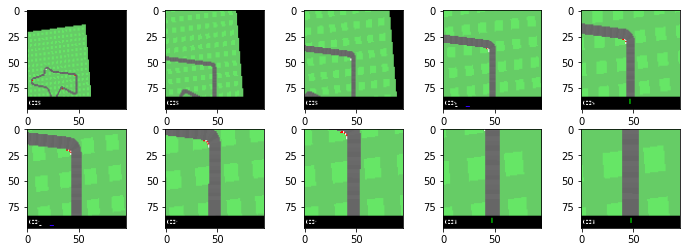

In [13]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_green)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

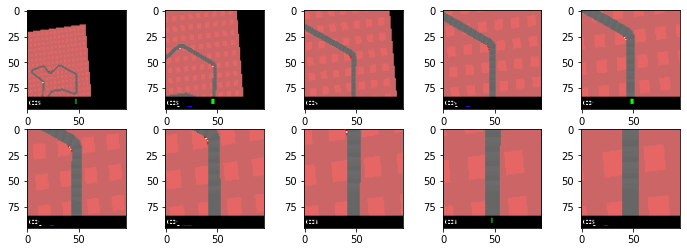

In [14]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_red)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

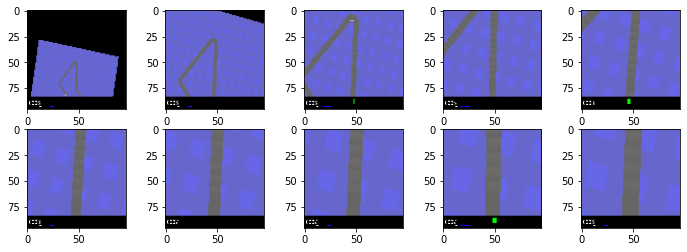

In [15]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_blue)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

# PPO Models

In [24]:
class Env():
    def __init__(self, color, seed = 0):
        self.env = gnwrapper.Animation(cr.CarRacing(color = color))
        self.env = cr.CarRacing(color = color)
        self.color = color
        self.env.seed(seed)
        self.reward_threshold = 1000

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = self.env.reset()
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * 4  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)

            if die: reward += 100

            if self.color == 'g':
              if np.mean(img_rgb[:, :, 1]) > 185.0:
                  reward -= 0.05
            total_reward += reward

            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break

        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def rgb2gray(rgb, norm=True):
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        if norm:
            gray = gray / 128. - 1.
        return gray

    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [57]:
env_green = Env(color = 'g', seed = 0)
obs_green = env_green.reset()

env_red = Env(color = 'r', seed = 0)
obs_red = env_red.reset()

env_blue = Env(color = 'b', seed = 0)
obs_blue = env_blue.reset()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1143..1442 -> 299-tiles track
Track generation: 1143..1442 -> 299-tiles track
Track generation: 1143..1442 -> 299-tiles track


In [58]:
obs_array = []
obs_array.extend(obs_green)
obs_array.extend(obs_red)
obs_array.extend(obs_blue)

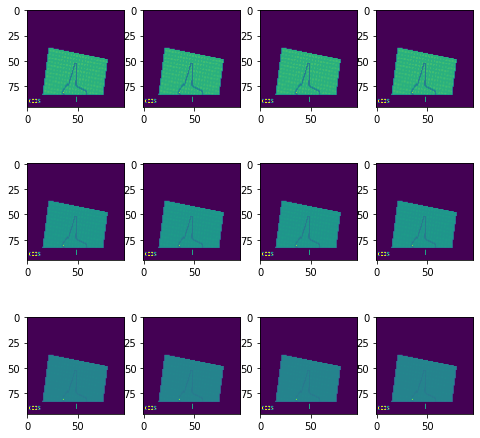

In [59]:
f, axs = plt.subplots(3, 4, figsize = (8, 8))
axs = axs.flatten()
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

In [84]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None  

class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),
        )

        self.cnn_base = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(True),
            nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
        )

        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)
      
    def forward(self, input, a = 0.1):
        feature = self.feature(input)

        out = self.cnn_base(feature)
        out = out.view(-1, 256)
        v = self.v(out)
        out = self.fc(out)

        alpha = self.alpha_head(out) + 1
        beta = self.beta_head(out) + 1

        feature = feature.view(-1, 64 * 5 * 5)
        reverse_feature = ReverseLayerF.apply(feature, a)
        domain_output = self.domain_classifier(reverse_feature)

        return (alpha, beta), v, domain_output

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

  

In [85]:
test_tensor = torch.rand((20, 4, 96, 96))
test_tensor.size()

dann = DANN()

feature = dann.feature(test_tensor)

print ("Feature exactor output size " + str(feature.size()))

out = dann.cnn_base(feature)
print ("Feature exactor output size " + str(out.size()))

out = out.view(-1, 256)
v = dann.v(out)
print ("v output size " + str(v.size()))

out = dann.fc(out)
alpha = dann.alpha_head(out) + 1
beta = dann.beta_head(out) + 1
print ("alpha output size " + str(alpha.size()))
print ("beta output size " + str(beta.size()))

feature = feature.view(-1, 64 * 5 * 5)
reverse_feature = ReverseLayerF.apply(feature, 0.1)
domain_output = dann.domain_classifier(reverse_feature)
print ("domain_classifier output size " + str(v.size()))


(alpha, beta), v, domain_output = dann(test_tensor)
print ("alpha output size " + str(alpha.size()))
print ("beta output size " + str(beta.size()))
print ("v output size " + str(v.size()))
print ("domain_classifier output size " + str(v.size()))


Feature exactor output size torch.Size([20, 64, 5, 5])
Feature exactor output size torch.Size([20, 256, 1, 1])
v output size torch.Size([20, 1])
alpha output size torch.Size([20, 3])
beta output size torch.Size([20, 3])
domain_classifier output size torch.Size([20, 1])
alpha output size torch.Size([20, 3])
beta output size torch.Size([20, 3])
v output size torch.Size([20, 1])
domain_classifier output size torch.Size([20, 1])


In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),
        )

        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v

In [66]:
transition = np.dtype([('s', np.float64, (4, 96, 96)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (4, 96, 96))])

In [68]:
class Agent():
    max_grad_norm = 0.5
    clip_param = 0.1
    ppo_epoch = 10
    buffer_capacity, batch_size = 2000, 128

    def __init__(self):
        self.training_step = 0
        self.net = Net().double().to(device)
        self.buffer = np.empty(self.buffer_capacity, dtype=transition)
        self.counter = 0

        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def save_param(self):
        torch.save(self.net.state_dict(), 'param/ppo_net_params.pkl')

    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.buffer['s_'], dtype=torch.double).to(device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        with torch.no_grad():
            target_v = r + 0.99 * self.net(s_)[1]
            adv = target_v - self.net(s)[1]
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                alpha, beta = self.net(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.optimizer.step()

In [69]:
if __name__ == "__main__":
    agent = Agent()
    env_green = Env(color = 'g', seed = 0)
    render = False

    training_records = []
    running_score = 0
    state = env_green.reset()
    for i_ep in range(100000):
        score = 0
        state = env_green.reset()

        for t in range(1000):
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = env_green.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
            if render:
                env_green.render()
            if agent.store((state, action, a_logp, reward, state_)):
                agent.update()
            score += reward
            state = state_
            if done or die:
                break
        running_score = running_score * 0.99 + score * 0.01

        if i_ep % 10 == 0:
            print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
        if running_score > env_green.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {}!".format(running_score, score))
            break

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1143..1442 -> 299-tiles track
Track generation: 1087..1369 -> 282-tiles track
Ep 0	Last score: -18.03	Moving average score: -0.18
Track generation: 964..1212 -> 248-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1176..1474 -> 298-tiles track
Track generation: 1283..1608 -> 325-tiles track
Track generation: 1217..1526 -> 309-tiles track
Track generation: 1096..1374 -> 278-tiles track
Track generation: 1198..1501 -> 303-tiles track
Track generation: 1159..1453 -> 294-tiles track
Track generation: 957..1205 -> 248-tiles track
Track generation: 1181..1480 -> 299-tiles track
Track generation: 979..1234 -> 255-tiles track
Track generation: 1320..1654 -> 334-tiles track
Ep 10	Last score: -27.64	Moving average score: -1.81
Track generation: 1067..1338 -> 271-tiles track
Track generation: 1067..1338 -> 271-tiles track
Track generation: 1207..1513 -> 306-tiles track
Track generation: 1106..1396 -> 290-tiles track
Tr

KeyboardInterrupt: ignored